# Notebook 1: Code for 'Identifying the phylogenetic utility of Raman spectra'

---

><font size="3"> This code contains all the code necessary to reproduce the results from the pub 'Identifying the phylogenetic utility of Raman spectra'. These analyses explore the presence of phylogenetic information in Raman spectra using a publicly available [dataset](https://www.nature.com/articles/s41467-019-12898-9) comprised of 30 clinically isolated strains of bacteria and fungi. 

><font size="3"> First, we will explore the relationship of strain-level spectra with different levels of the taxonomic hierarchy. We will then test for the presence of phylogenetic signal in the spectra and analyze the evolutionary patterns associated with conserved portions of the spectra. Finally, we will assess the extent to which features of the genome are predictive of evolutionary signals present in Raman spectra.
    
><font size="3"> All the necessary data and code are available via [GitHub](https://github.com/Arcadia-Science/raman-taxonomy).  
>
   
---

## Initiating workspace and loading data

<font size="3"> Set working directory.

In [5]:
library(here)
here::here('../') # Should be set to the root of the repository
setwd(here::here())

here() starts at /Users/ryanyork/Documents/Research/github/raman-taxonomy



[1] "/Users/ryanyork/Documents/Research/github/raman-taxonomy/../"

<font size="3"> Source functions.

In [6]:
suppressPackageStartupMessages(source('01_utils/R/raman-taxonomy-utils.R'))

<font size="3"> Load spectral data and config script (contains strain name info etc.).

In [158]:
# Load Ho et al. 2019 spectral data
x <- np$load("00_data/X_finetune.npy")

# Reverse to ensure wavenumbers are ascending
x <- x[, ncol(x):1]

# Load config (contains strain name info, etc.)
config <- source_python("00_data/config.py")

# Get names by ordering strains (have to +1 order since its 0 indexed as in python; R wants to start with 1)
n <- unlist(STRAINS)

# Load wavenumbers
wav <- rev(np$load("00_data/wavenumbers.npy"))

# Load taxonomic groups (collected from NCBI)
taxa <- read.csv("00_data/taxonomic_groups.csv")

<font size="3"> Calculate mean spectra for all strains.

In [17]:
# Calculate the mean spectra for all strains by splitting on strain and extracting column means
m <- lapply(split(as.data.frame(x), y), function(z)
  colMeans(z))

# Recombine
m <- do.call(rbind, m)

# Add rownames corresponding to strain ID
rownames(m) <- n

<font size="3"> Calculate the standard error across spectra for all strains.

In [18]:
# Calculate spectral standard error for all strains
se <- lapply(split(as.data.frame(x), y), function(z) {
  apply(z, 2, function(w)
    plotrix::std.error(w))
})

# Recombine
se <- do.call(rbind, se)

# Add rownames corresponding to strain ID
rownames(se) <- n

<font size="3"> Save means and standard errors as .RDS files.

In [19]:
saveRDS(se, '01_utils/ho_et_al_spectra_se.RDS')
saveRDS(m, '01_utils/ho_et_al_spectra_means.RDS')

## Visualizing spectra (as in Figure 1)

---

><font size="3"> In this section we will plot strain-level spectra (and their variation across experimental replicates), colored by taxonomic identity.

---

<font size="3"> Generate taxonomic matrix that matches length of sample matrix.

In [20]:
pred <-
  as.data.frame(cbind(apply(taxa, 2, function(x)
    rep(x, each = 100))))

<font size="3"> Set up colors using ArcadiaColorBrewer (coloring species by genus).

In [21]:
cols <-
  c(arcadia.pal(n = 6, name = "Accent"),
    arcadia.pal(n = 6, name = "Lighter_accents"))[1:length(unique(taxa$Genus))]
names(cols) <- unique(taxa$Genus)
cols <- cols[match(taxa$Genus, names(cols))]

<font size="3"> Plot all spectra and overlay mean spectrum (as in **Figure 1**).

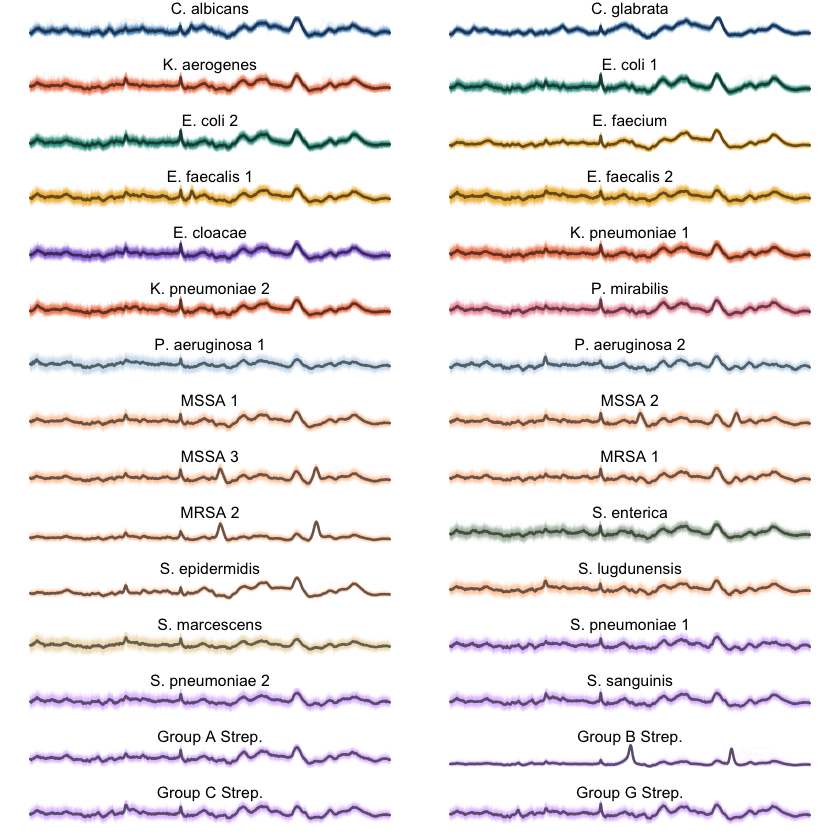

In [22]:
# Set up plot
par(mfrow = c(15, 2), mar = c(1, 1, 1, 1))

# Loop through and plot
for (i in 1:length(unique(pred$Strain))) {
  # Extract spectra
  tmp <- x[grep(unique(pred$Strain)[i], pred$Strain),]
  
  # Initiate plot
  plot(
    tmp[1,],
    col = alpha(cols[i], 0.05),
    type = "l",
    bty = "n",
    xaxt = "n",
    yaxt = "n",
    xlab = "",
    ylab = ""
  )
  
  # Add lines
  for (j in 2:nrow(tmp)) {
    lines(tmp[j,], col = alpha(cols[i], 0.05))
  }
  
  # Add mean
  lines(m[i,], lwd = 2, col = darken_color(cols[i], factor = 2))
  
  # Add label
  title(main = unique(pred$Strain)[i], font.main = 1)
}

## Comparing spectra as a function of taxonomic categories (as in Figure 2)

---
><font size="3"> In this section we will start to explore whether strains spectrally vary as a function of **taxonomy**. To do this, we will employ the taxonomic identity matrix we set up in the previous section (the object 'pred') to assess variation associated with different levels of the taxonomic hierarchy (i.e. strain, species, genus, family, etc.).
    
><font size="3"> First, we will compare how **generalized linear models (GLMs)** can model spectral variation using different taxonomic predictors.
>
---

<font size="3"> Since spectra are high-dimensional (~1000s of measurements) it is necessary to have a lower-dimensional representation of them to use for statistical tests.
    
<font size="3"> Here, we will use **PCA** to reduce spectral dimensions. 

In [23]:
pca <- prcomp(x)

<font size="3"> Plot variance explained.

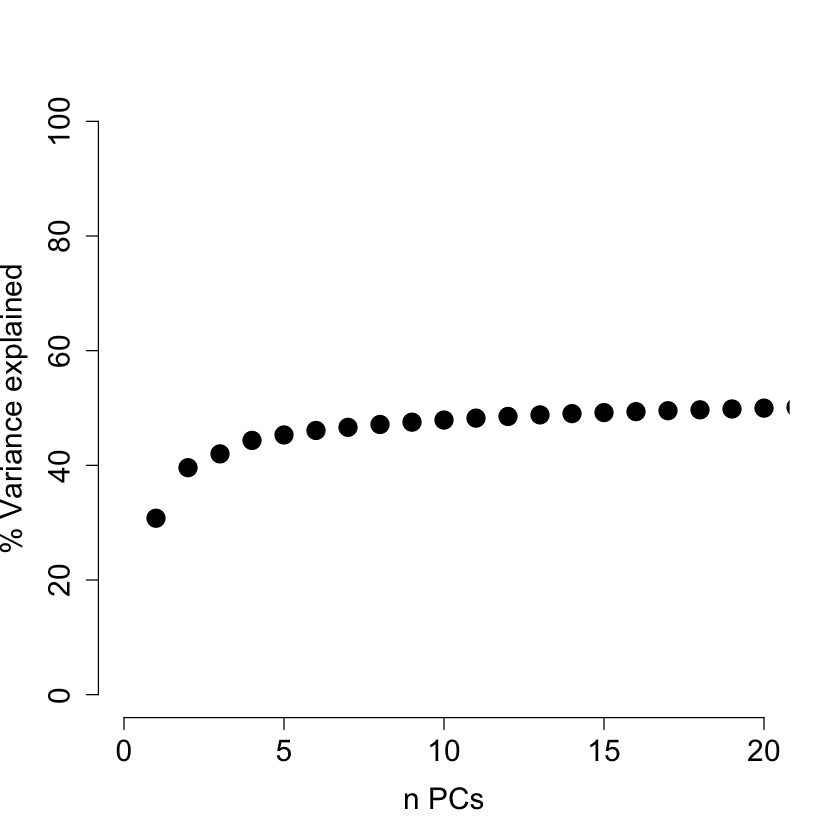

In [28]:
plot(
  cumsum((pca$sdev) ^ 2 / sum(((
    pca$sdev
  ) ^ 2)))[1:100] * 100,
  ylab = "% Variance explained",
  xlab = "n PCs",
  pch = 20,
  cex = 3,
  cex.axis = 1.5,
  cex.lab = 1.5,
  bty = "n",
  xlim = c(0, 20),
  ylim = c(0, 100)
)

<font size="3"> Construct a **GLM** for each set of taxonomic predictors using PC1 as the outcome variable.

In [84]:
# Generate empty list to save results
mods <- list()

# Loop through and construct GLMs
for (i in 1:(ncol(pred))) {
  mods[[colnames(pred)[i]]] <- lm(pca$x[, 1] ~ pred[, i])
}

<font size="3"> Next, we want to be able to assess how well each taxonomic category predicts spectral variation via the different GLMs. To do so, we will calculate the fit of each model using **BIC**.

In [90]:
bics <- lapply(mods, function(x)
  BIC(x))

<font size="3"> Plotting the BIC values will let us assess the different models (as in **Figure 2, B**).

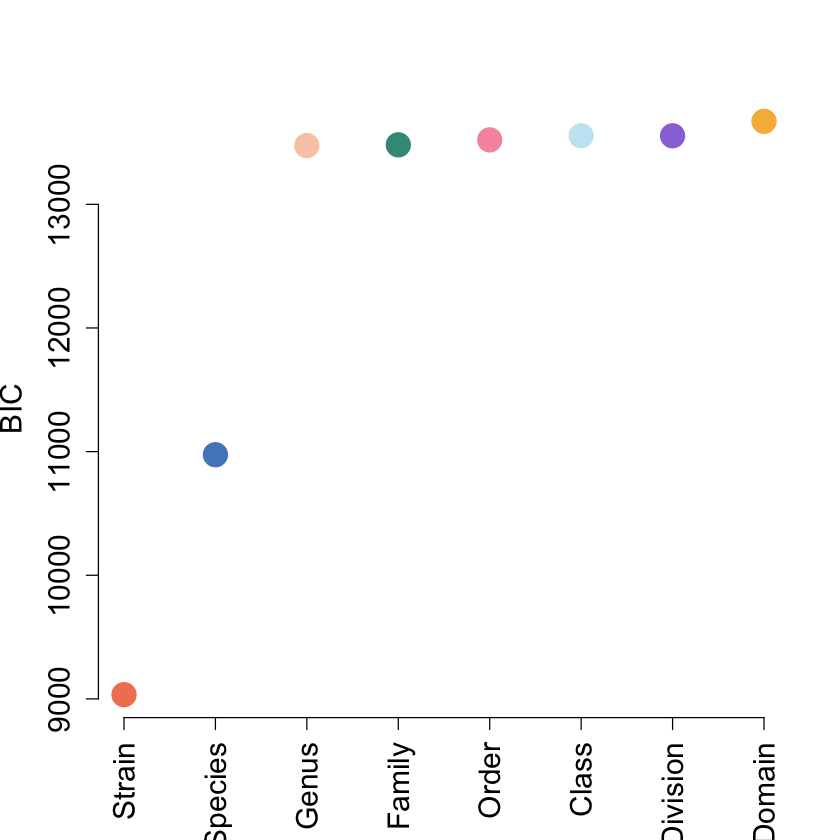

In [91]:
# Order the BIC values
bics <- unlist(bics)
bics <- bics[order(bics)]

# Set up colors
cols <-
  c(arcadia.pal(n = 6, name = "Accent"),
    arcadia.pal(n = 6, name = "Lighter_accents"))[1:length(bics)]
names(cols) <-
  c("Species",
    "Strain",
    "Family",
    "Domain",
    "Division",
    "Order",
    "Class",
    "Genus")
cols <- cols[match(names(bics), names(cols))]

# Plot
plot(
  bics,
  pch = 20,
  cex = 4,
  col = cols,
  ylab = "BIC",
  xlab = "",
  cex.lab = 1.5,
  cex.axis = 1.5,
  xaxt = "n",
  bty = "n"
)

# Add axis
axis(1,
     1:length(bics),
     names(bics),
     cex.axis = 1.5,
     las = 2)

---
><font size="3"> From the above analyses it appears that models using **strain** and **species** identity as predictors have much fits that then other taxonomic categories. 
    
><font size="3"> To complement these models, we will next explore rates intra-taxonomic variation (a potential contributor to the observed model fit variation) using **cosine similarity**.
>
---

<font size="3"> Calculate all-by-all cosine similarity.

In [47]:
d <- lsa::cosine(t(x))

<font size="3"> Visualize the overall cosine similarity distribution with a histogram.

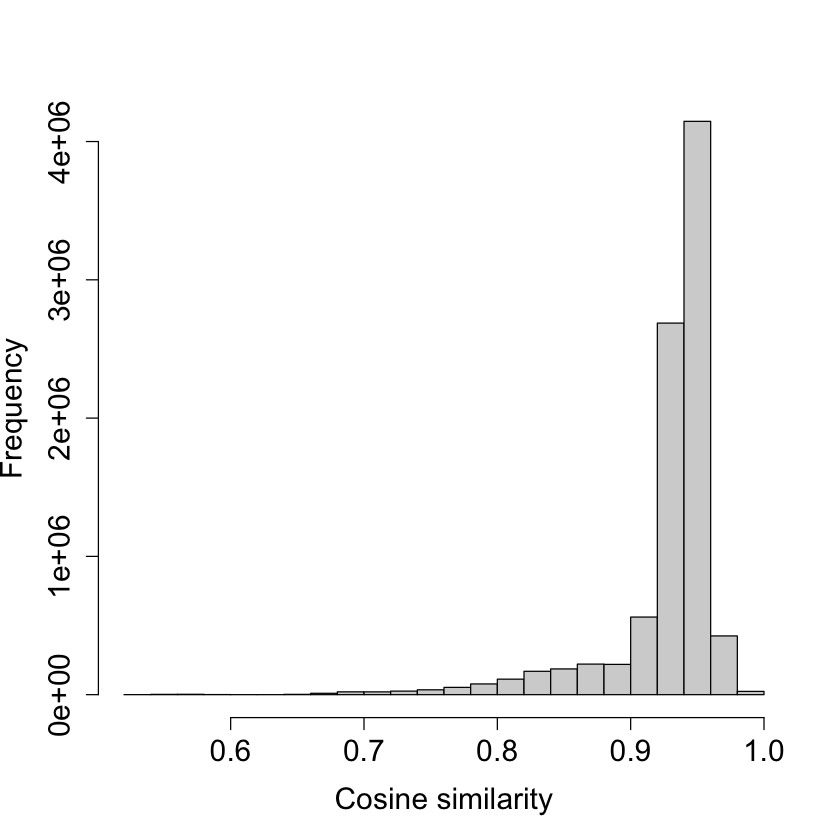

In [50]:
hist(
  unlist(as.data.frame(d)),
  cex.lab = 1.5,
  cex.axis = 1.5,
  xlab = "Cosine similarity",
  main = ""
)

<font size="3"> Extract cosine similarities for each taxonomic group.

In [98]:
# Generate empty list to save results in
res <- list()

# Loop through the taxonimc group matrix ('pred') and extract cosine similarites for all associated strains
for (i in 1:(ncol(pred))) {
  # Split cosine similarity matrix on taxonomic unit
  tmp <- split(as.data.frame(d), pred[, i])
  
  # Loop through and calculate mean per strain
  for (j in 1:length(tmp)) {
    tmp[[j]] <- tmp[[j]][, pred[, i] %in% names(tmp)[j]]
    tmp[[j]] <- tmp[[j]][!tmp[[j]] == 1]
    tmp[[j]] <- mean(tmp[[j]])
  }
  
  # Add to results list
  res[[colnames(pred)[i]]] <- unlist(tmp)
}

<font size="3"> Calculate statistics for plotting per-taxa cosine similarity.

In [99]:
# Mean per group
m1 <- unlist(lapply(res, function(y)
  mean(y)))

# Standard error
se1 <- unlist(lapply(res, function(y)
  plotrix::std.error(y)))

# Variance
v1 <- unlist(lapply(res, function(y)
  var(y)))

<font size="3"> Plot per-taxa variance (as in **Figure 2, C**).

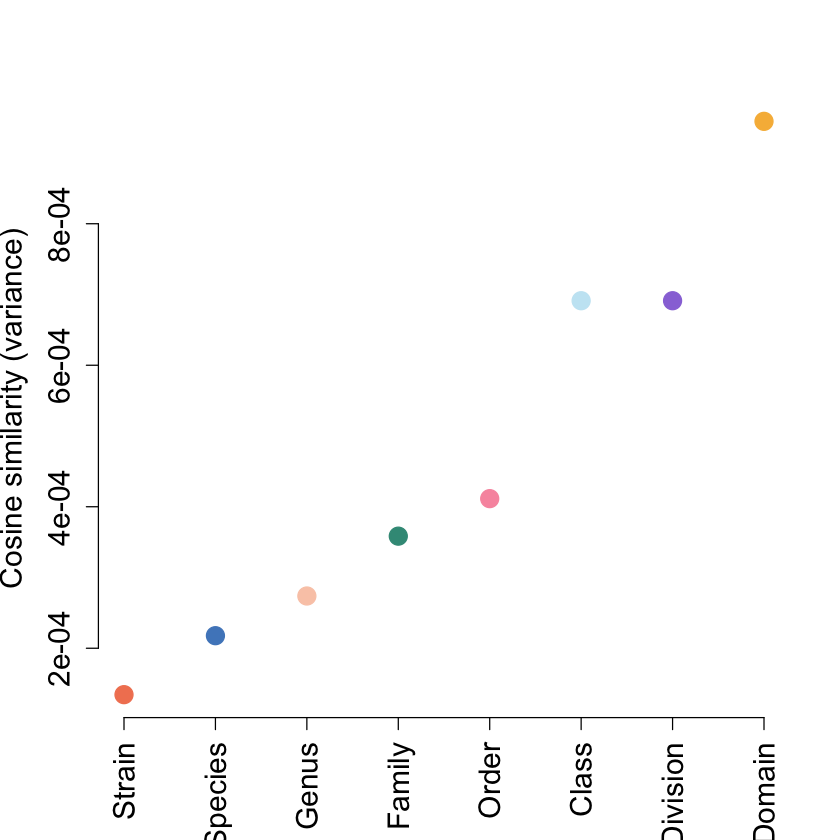

In [100]:
# Order variance measures
o <- order(v1)

# Set up colors
cols <-
  c(arcadia.pal(n = 6, name = "Accent"),
    arcadia.pal(n = 6, name = "Lighter_accents"))[1:length(v1)]
names(cols) <-
  c("Species",
    "Strain",
    "Family",
    "Domain",
    "Division",
    "Order",
    "Class",
    "Genus")
cols <- cols[match(names(v1[o]), names(cols))]

# Plot
plot(
  v1[o],
  pch = 20,
  cex = 3,
  col = cols,
  # ylim = c(0.92, 0.97),
  ylab = "Cosine similarity (variance)",
  xlab = "",
  cex.lab = 1.5,
  cex.axis = 1.5,
  xaxt = "n",
  bty = "n"
)

# Add axis
axis(1,
     1:length(v1),
     names(v1)[o],
     cex.axis = 1.5,
     las = 2)

## Calculating and analyzing phylogenetic signal (as in Figure 3)

---
><font size="3"> The above analyses suggest that Raman spectra vary strongly as a function of taxonomy. In this section we will test if this variation is distributed evenly across the spectrum or, alternatively, if different portions are more predictive of phylogenetic identity.
    
><font size="3"> We will first calculate **phylogenetic signal** (i.e. a measure of how associated a given trait measurement - here, Raman spectra - is with a phylogenetic tree) as a function of spectral position using window-based analyses.

>
---

<font size="3"> Load phylogeny (downloaded from **timetree.org** using a taxa name query).

In [92]:
phylo <-
  read.newick("00_data/ho_2019_species_list_for_timetree.nwk")

<font size="3"> Drop *Streptococcus agalactiae* as its spectrum appears to be a major outlier, possibly an experimental artifact.

In [94]:
phylo <- drop.tip(phylo, "Streptococcus_agalactiae")

<font size="3"> Calculate mean spectra per species.

In [101]:
# Split the mean spetrum matrix on species name
m2 <-
  split(as.data.frame(m), paste(taxa$Genus, taxa$Species, sep = "_"))

# Calculate mean spectra by species
m2 <- lapply(m2, function(x)
  colMeans(x))

# Recombine
m2 <- do.call(rbind, m2)

# Remove Streptococcus agalactiae
m2 <- m2[!rownames(m2) == "Streptococcus_agalactiae",]

<font size="3"> Reduce the dimensionality of the mean spectra using PCA.

In [103]:
pca <- prcomp(m2)

<font size="3"> Compute phylogenetic signal within windows of size *n* along the spectrum.

In [105]:
# Set length
len <- 25

# Extract spectral windows of desired size using the function 'split_with_overlap'
win <- split_with_overlap(t(m2), len, len - 1)[1:(ncol(m2) - len)]

# Generate empty list for saving results
win_phy <- list()

# Loop and calculate phylogenetic signal
for (i in 1:length(win)) {
  # Reduce the dimensions of spectra in the window from size n to 1 via PCA
  p <- prcomp(t(win[[i]]))
  
  # Match PCA results with phylogeny ordering
  p <- p$x[match(phylo$tip.label, rownames(p$x)), 2]
  
  # Reduce the dimensions of spectra in the window from size n to 1 via calculating the mean
  mn <- colMeans(win[[i]])
  
  # Compute phylogenetic signal using spectral means
  mn <- phylosig(phylo, mn, method = "lambda")[1]$lambda
  
  # Compute phylogenetic signal using PC1
  p <- phylosig(phylo, p, method = "lambda")[1]$lambda
  
  # Combine into a list
  l <- list(mn, p)
  
  # Add names
  names(l) <- c("mean", "pca")
  
  # Add to results list
  win_phy[[as.character(i)]] <- l
}

# Extract results for PC ('pc') and spectral mean ('mn') metrics
pc <- unlist(lapply(win_phy, function(x)
  x$pca))
mn <- unlist(lapply(win_phy, function(x)
  x$mean))

<font size="3"> Plot window-based phylogenetic signal (as in **Figure 3, A**).

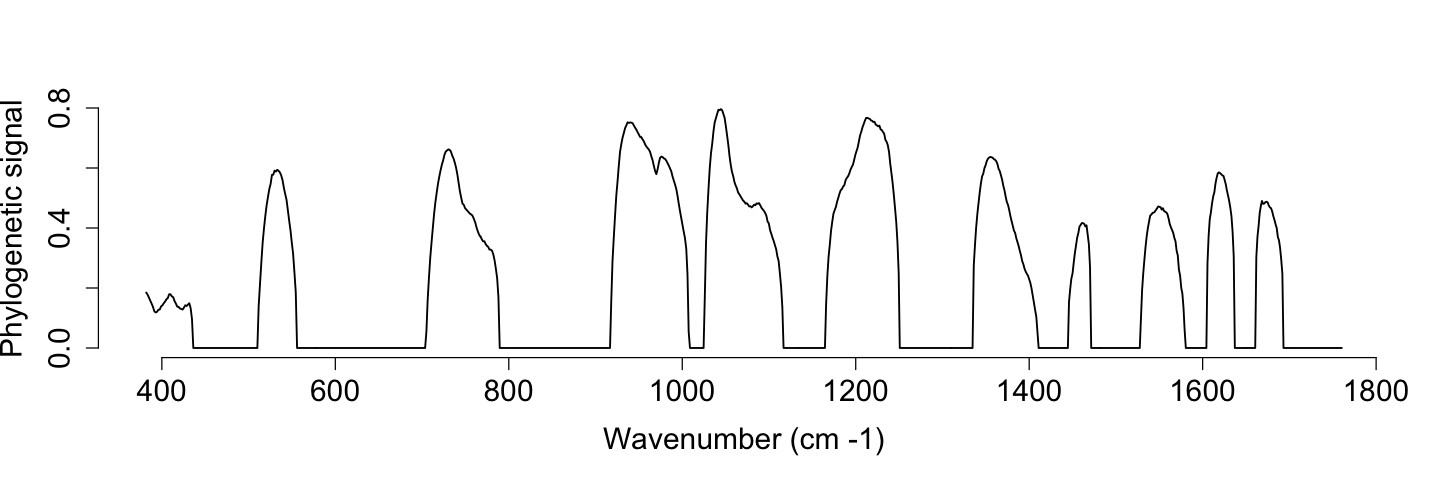

In [109]:
options(repr.plot.width = 12, repr.plot.height = 4)
plot(
  wav[1:length(mn)],
  mn,
  type = "l",
  lwd = 1.5,
  bty = "n",
  ylim = c(0, 0.8),
  cex.axis = 1.5,
  cex.lab = 1.5,
  ylab = "Phylogenetic signal",
  xlab = "Wavenumber (cm -1)"
)

---
><font size="3"> We observe above that there are clear bands within the spectrum that display conservation (elevated phylogenetic signal). Since these types of patterns can be arrived at by different phylogenetic relationships, we will next start to explore whether or not these bands reflect varying types of trait differentiation among species. 
    
><font size="3"> To do so, we will calculate the distance between species spectra within windows and connect this to the phylogeny, allowing us to infer the differences (**spectral distance**) between species over evolutionary time.
>
---

<font size="3"> Calculate **spectral distance** as a function of position.

In [113]:
# Set length
len <- 25

# Extract spectral windows of desired size using the function 'split_with_overlap'
win <- split_with_overlap(t(m2), len, len - 1)[1:(ncol(m2) - len)]

# Generate empty list for saving results
win_dist <- list()

# Loop and calculate phylogenetic signal
for (i in 1:length(win)) {
  # Calculate distance between strains
  p <- as.matrix(dist(t(win[[i]])))
  
  # Add to results list
  win_dist[[as.character(i)]] <- unlist(as.data.frame(p))
}

# Combine results in matrix
win_dist <- do.call(cbind, win_dist)

<font size="3"> To be able to analyze **spectral distance** over evolutionary time we need to know the divergence time between all species in our tree. This can be obtained by calculating the **cophenic distances** between all species, giving us a specific measure of divergence in years between species.

In [119]:
# Generate empty list to save results
cophen_times <- list()

# Loop and calculate cophenic distance in windows
for (i in 1:length(win)) {
  # Empty list to save results
  res <- list()
  
  # Calculate distance in window
  d <- as.matrix(dist(t(win[[i]])))
  
  # Convert to three column matrix
  d <- as.data.frame(as.table(d))
  
  # Looop through and calculate as a function of time
  for (j in 0:round(max(p$Freq))) {
    # Filter on cophenetic distances
    z <- d[which(p$Freq >= j),]
    
    # Remove self comparisons
    z <- z[!z[, 1] == z[, 2],]
    
    # Add to list
    res[[as.character(j)]] <- z
  }
  
  # Calculate mean
  p_mean <- unlist(lapply(res, function(x)
    mean(x$Freq)))
  
  # Add to list
  cophen_times[[as.character(i)]] <- p_mean
}

# Combine into matrix
time_mat <- do.call(cbind, cophen_times)

<font size="3"> Visualize as a heatmap (x-axis is spectral position).

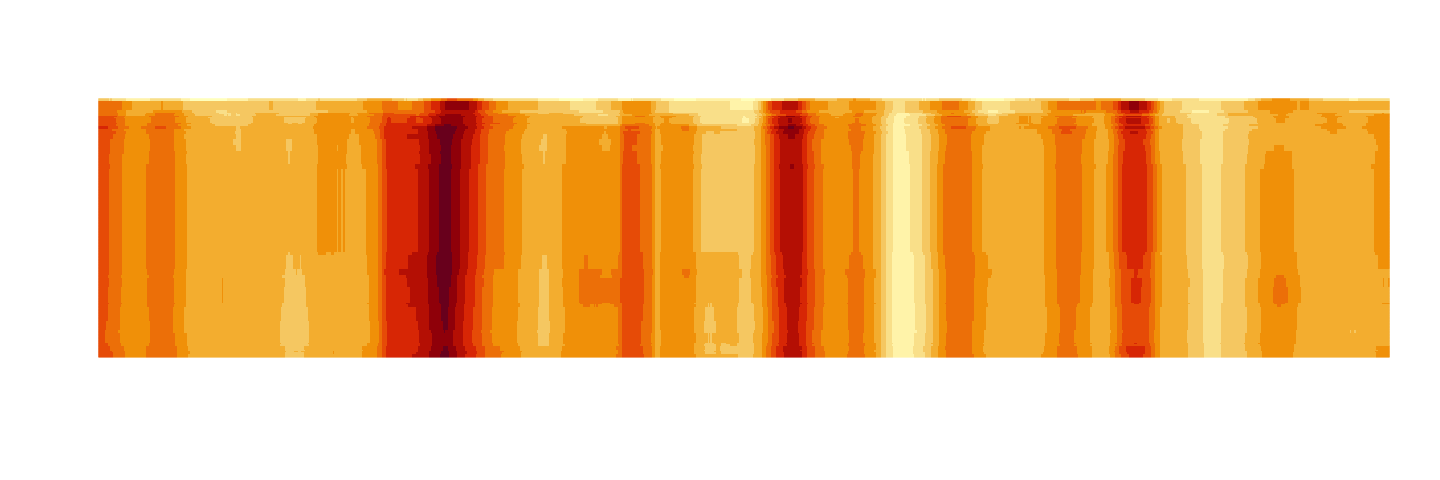

In [153]:
options(repr.plot.width=12, repr.plot.height=4)

# Heatmap
image(t(time_mat),
      xaxt = "n",
      yaxt = "n",
      bty = "n")

# Add line corresponding to max distance
y <-
  t(unlist(lapply(cophen_times, function(x)
    which.max(x) / length(x))))
x <- (1:length(y) / length(y))
lines(x, y, lwd = 3)

---
><font size="3"> It appears that **spectral distance** varies quite a bit as a function of position, suggesting that different parts of the Raman spectra may reflect different evolutionary relationships among species (e.g. greater spectral distances at ancient nodes or smaller distances distributed evenly across time). 
    
><font size="3"> Next, let's see if these patterns reflect specific relationships between spectral differences and the phylogenetic tree. To do this we will calculate the distance between trees made from spectral relationships and the phylogenetic tree using the **Robinson-Foulds metric**.
---

<font size="3"> Calculate distance from tree in windows (using the Robinson-Foulds metric).

In [147]:
# Set length
len <- 25

# Generate empty list to save results
win_tree <- list()

# Loop and calculate tree distances
for (i in 1:length(win)) {
  # Generate a tree for given window using neighbor joining
  z <- as.phylo(nj(dist(t(win[[i]]))))
  
  # Compare to the phylogenetic tree using the 'TreeDistance' function (Robinson-Foulds metric)
  win_tree[[as.character(i)]] <- TreeDist::TreeDistance(phylo, z)
}

<font size="3"> Plot.

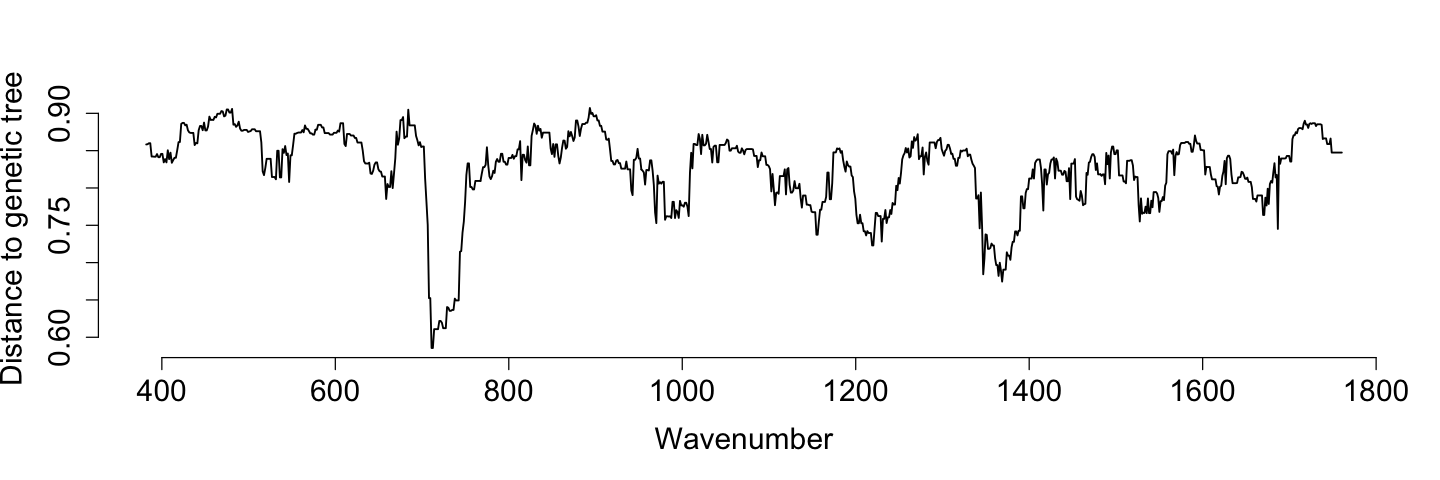

In [151]:
options(repr.plot.width=12, repr.plot.height=4)

plot(
  wav[1:length(win_tree)],
  unlist(win_tree),
  type = "l",
  lwd = 1.5,
  ylab = "Distance to genetic tree",
  cex.axis = 1.5,
  cex.lab = 1.5,
  bty = "n",
  xlab = "Wavenumber"
)

---
><font size="3"> Now let's jointly visualize phylogenetic signal, spectral distance, and tree distance to allow investigation of there relationships.
>
---

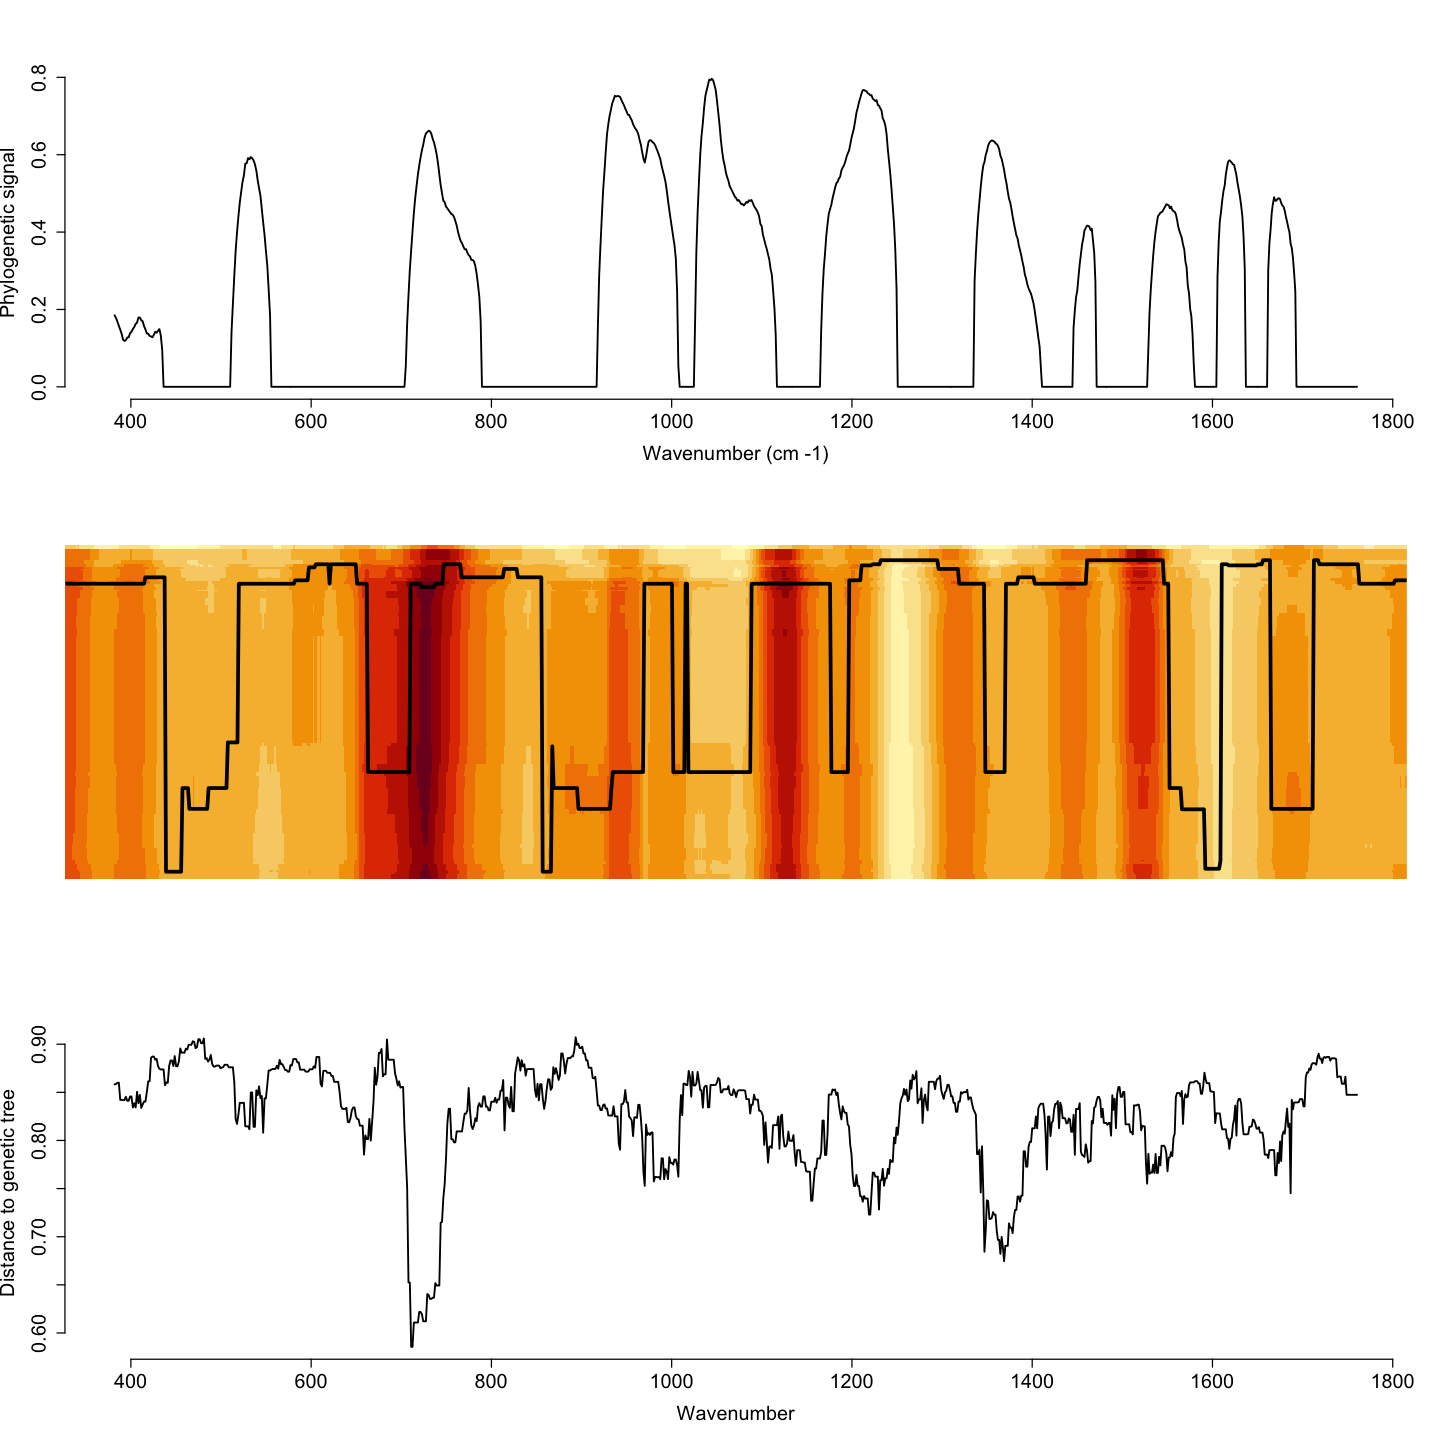

In [155]:
options(repr.plot.width = 12, repr.plot.height = 12)
par(mfrow = c(3, 1))

# Phylogenetic signal
plot(
  wav[1:length(mn)],
  mn,
  type = "l",
  lwd = 1.5,
  bty = "n",
  ylim = c(0, 0.8),
  cex.axis = 1.5,
  cex.lab = 1.5,
  ylab = "Phylogenetic signal",
  xlab = "Wavenumber (cm -1)"
)

# Spectral distance
image(t(time_mat),
      xaxt = "n",
      yaxt = "n",
      bty = "n")
y <-
  t(unlist(lapply(cophen_times, function(x)
    which.max(x) / length(x))))
x <- (1:length(y) / length(y))
lines(x, y, lwd = 3)

# Tree distance
plot(
  wav[1:length(win_tree)],
  unlist(win_tree),
  type = "l",
  lwd = 1.5,
  ylab = "Distance to genetic tree",
  cex.axis = 1.5,
  cex.lab = 1.5,
  bty = "n",
  xlab = "Wavenumber"
)

## Compare phylogenetic signal and genome features (As in Figure 4)

---
><font size="3"> Finally, in this section will see if features of the genome (e.g. number of proteins or GC content) reflect the patterns observed in the previous sections. 
    
><font size="3"> We will use genomic summary statistics collect from [NCBI]("https://www.ncbi.nlm.nih.gov/genome/") to do this (pre-compiled, provided with this GitHub repository).   
>
---

<font size="3"> Load and clean genome feature data.

In [163]:
# Load genome statistics
size <-
  read.csv("00_data/ho_2019_expanded_genome_statistics.csv")

# Clean and convert to data frame
size <-
  as.data.frame(apply(size, 2, function(x)
    gsub("\\,", "", x)))

# Match genome size matrix to order of spectral data
size <- size[match(rownames(pca$x), gsub(" ", "_", size$Genome)),]

# Remove 'Streptococcus_agalactiae'
size <- size[!size$Genome == "Streptococcus agalactiae",]                    

<font size="3"> Compare the relationship between genome features and spectra in windows.

In [164]:
# Set length
len <- 25

# Generate empty list to save results
mods <- list()

# Loop through and calculate
for (i in 1:(ncol(m2) - len)) {
  # Extract mean strain spectra for given window
  d <- m2[, i:(i + len)]
  
  # PCA
  pca <- prcomp(d)
  
  # Fit GLMs for each genomic feature within the given window
  o <-
    apply(size[, 2:ncol(size)], 2, function(x)
      summary(lm(pca$x[, 1] ~ as.numeric(x)))[9])
  
  # Add to list
  mods[[as.character(i)]] <- o
}

<font size="3"> Plot with phylogenetic signal.

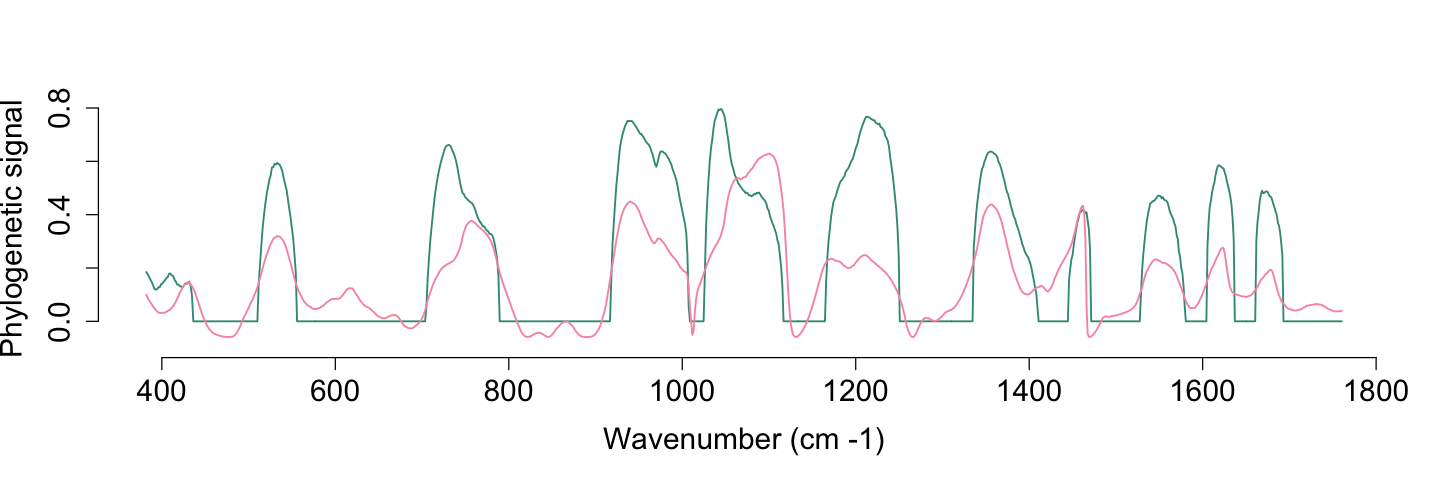

In [170]:
# Plot phylogenetic signal
plot(
  wav[1:length(mn)],
  mn,
  type = "l",
  bty = "n",
  col = "#3B9886",
  ylim = c(-0.1, 0.8),
  cex.axis = 1.5,
  cex.lab = 1.5,
  lwd = 1.5,
  ylab = "Phylogenetic signal",
  xlab = "Wavenumber (cm -1)"
)

# Add GC line
lines(wav[1:length(mn)],
      lwd = 1.5,
      unlist(lapply(mods, function(x)
        x$GC.)),
      col = "#F898AE")

<font size="3"> Predict phylogenetic signal via GLM using the genome feature models.

In [165]:
mod <- lm(
  mn ~ unlist(lapply(mods, function(x)
    x$Size..Mb.)) +
    unlist(lapply(mods, function(x)
      x$GC.)) +
    unlist(lapply(mods, function(x)
      x$Protein)) +
    unlist(lapply(mods, function(x)
      x$rRNA)) +
    unlist(lapply(mods, function(x)
      x$tRNA)) +
    unlist(lapply(mods, function(x)
      x$Other.RNA)) +
    unlist(lapply(mods, function(x)
      x$Gene)) +
    unlist(lapply(mods, function(x)
      x$Pseudogene))
)

<font size="3"> Analyse the model.

In [200]:
summary(mod)


Call:
lm(formula = mn ~ unlist(lapply(mods, function(x) x$Size..Mb.)) + 
    unlist(lapply(mods, function(x) x$GC.)) + unlist(lapply(mods, 
    function(x) x$Protein)) + unlist(lapply(mods, function(x) x$rRNA)) + 
    unlist(lapply(mods, function(x) x$tRNA)) + unlist(lapply(mods, 
    function(x) x$Other.RNA)) + unlist(lapply(mods, function(x) x$Gene)) + 
    unlist(lapply(mods, function(x) x$Pseudogene)))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.40938 -0.10311  0.00926  0.08965  0.35835 

Coefficients:
                                               Estimate Std. Error t value
(Intercept)                                     0.03025    0.01163   2.601
unlist(lapply(mods, function(x) x$Size..Mb.))   1.11312    0.13487   8.253
unlist(lapply(mods, function(x) x$GC.))         1.35014    0.21450   6.294
unlist(lapply(mods, function(x) x$Protein))     2.35705    2.60122   0.906
unlist(lapply(mods, function(x) x$rRNA))        0.21452    0.14902   1.440
unlist(lapply(mods, 

<font size="3"> Correlate window-based phylogenetic signal with genome feature associations.

In [171]:
# Generate empty vector to save results
cors <- c()

# Loop and correlate
for (i in 1:length(mods[[1]])) {
  cors <- c(cors, cor(mn, unlist(lapply(mods, function(x)
    x[i]))))
}

# Add genome feature names
names(cors) <- names(mods[[1]])

<font size="3"> Plot correlation coefficients.

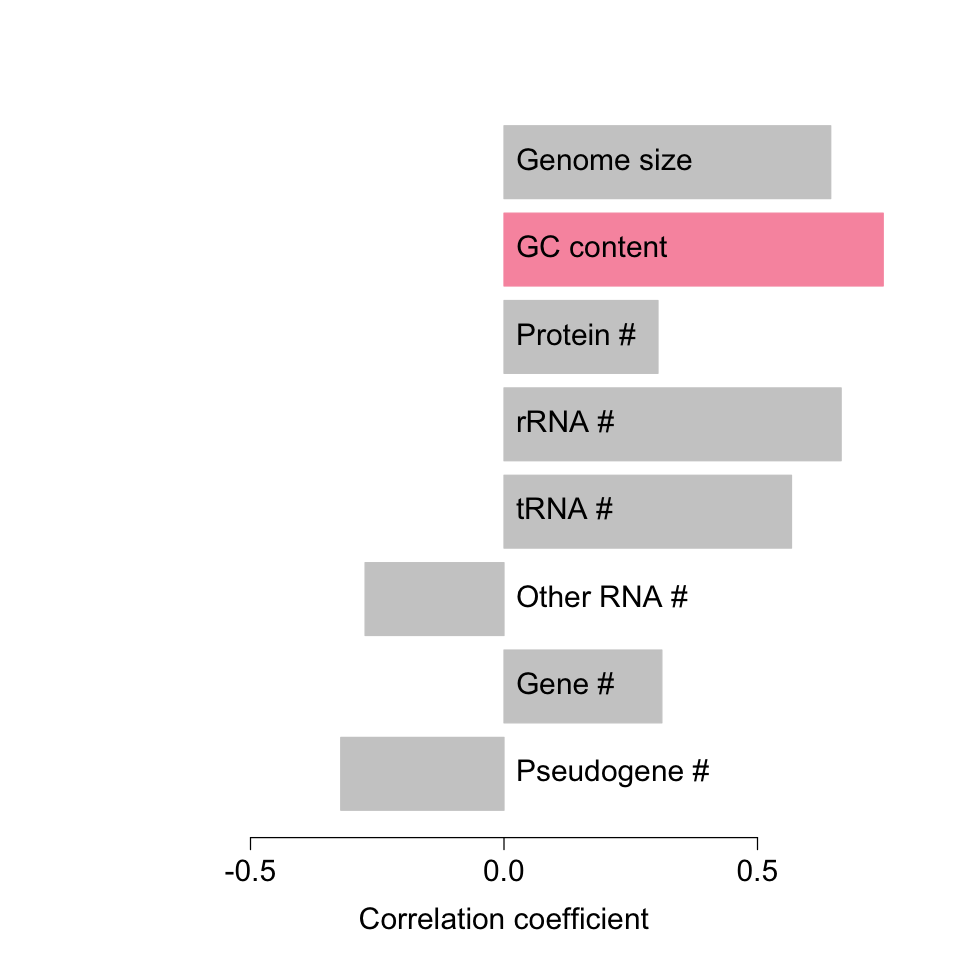

In [197]:
options(repr.plot.width=8, repr.plot.height=8)

# Plot
bp <- barplot(
  rev(cors),
  horiz = TRUE,
  xlim = c(-0.8, 0.8),
  las = 1,
  xlab = "Correlation coefficient",
  ylab = "",
  cex.lab = 1.5,
  cex.axis = 1.5,
  names.arg = "",
  col = c(rep("gray80", 6), "#F898AE", "gray80"),
  border = c(rep("gray80", 6), "#F898AE", "gray80")
)

# Add labels
lab <-
  c(
    "Genome size",
    "GC content",
    "Protein #",
    "rRNA #",
    "tRNA #",
    "Other RNA #",
    "Gene #",
    "Pseudogene #"
  )
text(0, bp, rev(lab), cex = 1.5, pos = 4)